In [1]:
#%config IPCompleter.use_jedi=False
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from pandas._libs.tslibs.timestamps import Timestamp
from pandas.core.frame import DataFrame
from pandas.core.series import Series
from matplotlib.axes._axes import Axes
from numpy import ndarray

sys.path.append('..')
from cyclingEfficiency import Clean, Eda, Utils, Visualize
plt.style.use('seaborn-v0_8')

El objetivo en este punto es extraer muestras y determinar el promedio del indicador de eficiencia que genera cada una. Este muestreo se hará por cada rango de cadencia y así se tendrá una base de datos homogénea y permitirá determinar cuál es el nivel de cadencia más eficiente. Para cada rango de cadencia se generará el promedio en terreno llano, terreno con elevación y uno general, con el fin de definir si existen diferencias en el comportamiento según el terreno.

In [3]:
hr_max: int = 190
bike_weight: float = 11
cad_min: int = 55
cad_max: int = 105
cad_step: int = 5
kph_greater: float = 0
hr_grater: float = 0
slope_greater_than_equal: float = 0
zone_grater_than_equal: int = 1
before: bool = False

data: DataFrame = Clean(
        hr_max=hr_max,
        kph_greater=kph_greater,
        cad_greater_than_equal=cad_min,
        hr_grater=hr_grater,
        slope_greater_than_equal=slope_greater_than_equal,
        zone_grater_than_equal=zone_grater_than_equal,
        before=before            
    ).data

data = Eda(
    data=data,
    bike_weight=bike_weight,
    cad_min=cad_min,
    cad_max=cad_max,
    cad_step=cad_step
).data

In [4]:
samples_list: list = []
samples_all: list = []
samples_plain: list = []
samples_hill: list = []
zones: ndarray = data['cad_zone'].unique()
zones.sort()
bash_size: int = 60 * 5

for i, zone_name in enumerate(zones):
    zone_num: int = i + 1
    sample_all: list[float] = Utils.generate_sample_data(
        data=data[
                data['cad_zone_num'] == zone_num
            ]['performance_indicator'],
        bash_size=bash_size,
    )

    sample_pĺain: list[float] = Utils.generate_sample_data(
        data=data[
                (data['cad_zone_num'] == zone_num) &
                (data['is_plain'] == 1)
            ]['performance_indicator'],
        bash_size=bash_size,
    )

    sample_hill: list[float] = Utils.generate_sample_data(
        data=data[
                (data['cad_zone_num'] == zone_num) &
                (data['is_plain'] == 0)
            ]['performance_indicator'],
        bash_size=bash_size,
    )

    samples_list.extend(
        [
            (
                zone_num , zone_name, all_value, plain, hill
            ) for all_value, plain, hill in zip(
                sample_all, sample_pĺain, sample_hill
            ) 
        ]
    )

samples: DataFrame = pd.DataFrame(
    samples_list,
    columns=[
        'cad_zone_num', 'cad_zone', 
        'all', 'plain', 'hill'
    ]
)

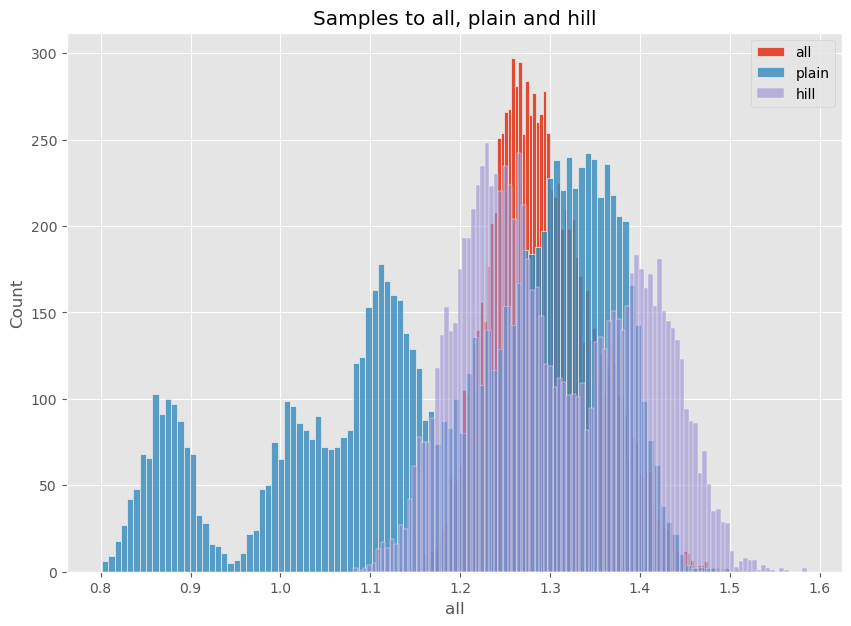

In [5]:
bins: int = 100
plt.figure(figsize=(10, 7))
sns.histplot(
    data=samples['all'],
    label='all',
    bins=bins,
    alpha=1
)
sns.histplot(
    data=samples['plain'],
    label='plain',
    bins=bins,
    alpha=0.8
)
sns.histplot(
    data=samples['hill'],
    label='hill',
    bins=bins,
    alpha=0.6
)
plt.title('Samples to all, plain and hill')
plt.legend()
plt.show()

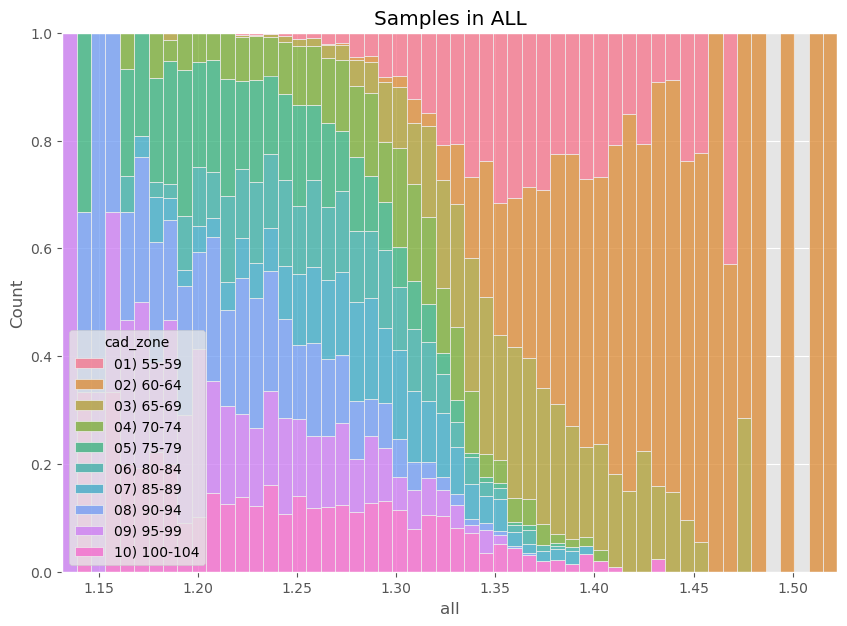

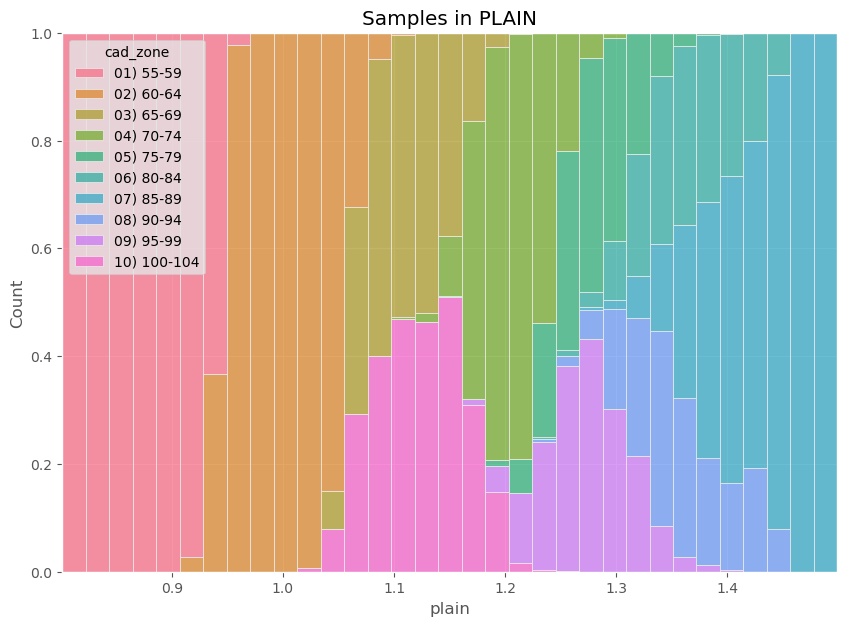

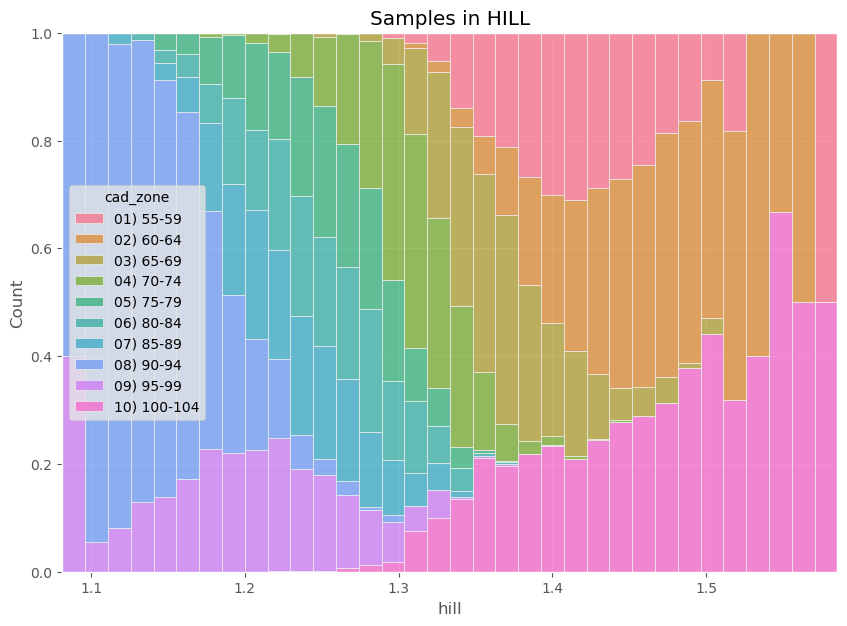

In [6]:
columns = ['all', 'plain', 'hill']
for variable in columns:
    plt.figure(figsize=(10, 7))
    sns.histplot(
        samples,
        x=variable,
        hue='cad_zone',
        multiple='fill'
    )
    plt.title('Samples in {}'.format(variable.upper()))
    plt.show()

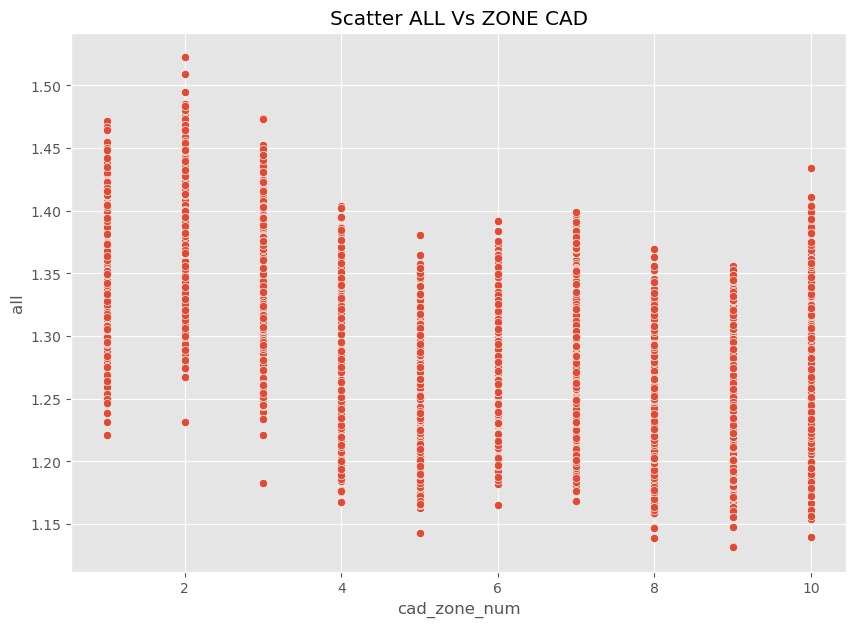

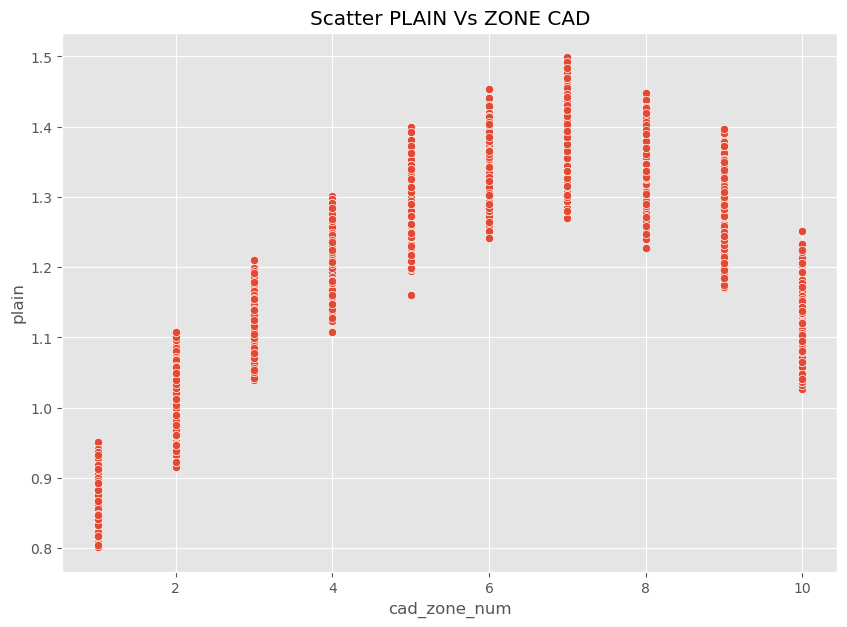

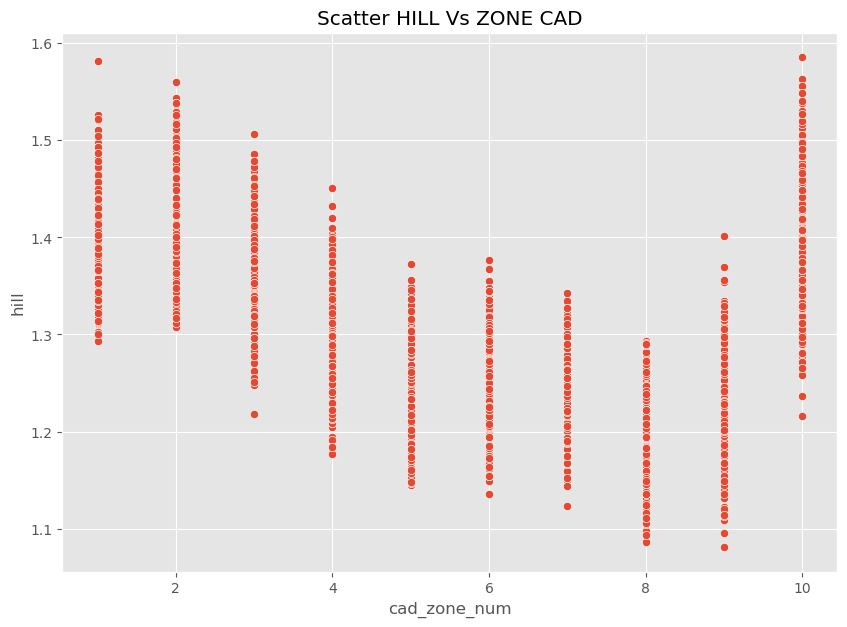

In [7]:
for variable in columns:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=samples,
        x='cad_zone_num',
        y=variable
    )
    plt.title('Scatter {} Vs ZONE CAD'.format(variable.upper()))
    plt.show()